credit : https://colab.research.google.com/drive/1fGKoS1WH6dbw3mYffOgTtdmPN2Wi9doF?usp=sharing

### Install libraries

In [ ]:
!pip install datasets transformers[sentencepiece] lightning scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
import pytorch_lightning as pl
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#### Load dataset

In [ ]:
#load dataset
raw_datasets = load_dataset("wongnai_reviews")
df = pd.DataFrame(raw_datasets["train"])
df.head()

README.md:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.27M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6203 [00:00<?, ? examples/s]

,review_body,star_rating
0,ร้านอาหารใหญ่มากกกกกกก \nเลี้ยวเข้ามาเจอห้องน้...,2
1,อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา...,3
2,ปอเปี๊ยะสด ทุกวันนี้รู้สึกว่าหากินยาก (ร้านที่...,2
3,รัานคัพเค้กในเมืองไทยมีไม่มาก หลายๆคนอาจจะสงสั...,4
4,อร่อย!!! เดินผ่านDigital gatewayทุกวัน ไม่ยักร...,4


In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['review_body', 'star_rating'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review_body', 'star_rating'],
        num_rows: 6203
    })
})

#### Load model (Phayathaibert)

In [ ]:
#tokenize dataset
checkpoint = "clicknext/phayathaibert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_dataset(dataset):
    encoded = tokenizer(
        dataset["review_body"],
        padding="max_length",
        max_length=128,
        truncation=True,
    )
    return encoded.data

#เเบ่ง train, validate dataset
train_df, eval_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["star_rating"],  # Stratify ตามค่าใน column "star_rating"
    random_state=42
)

train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

# สร้าง dataset ใหม่
small_train_dataset = train_dataset.map(tokenize_dataset, batched=True)
small_eval_dataset = eval_dataset.map(tokenize_dataset, batched=True)

# Rename target column to 'labels'
small_train_dataset = small_train_dataset.rename_column("star_rating", "label")
small_eval_dataset = small_eval_dataset.rename_column("star_rating", "label")

# Set the format of the datasets to return PyTorch tensors
small_train_dataset.set_format("torch")
small_eval_dataset.set_format("torch")

# Data loaders using the datasets directly
train_loader = DataLoader(small_train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(small_eval_dataset, batch_size=16, shuffle=False)

class HuggingFaceDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        input_ids = torch.tensor(item["input_ids"])
        attention_mask = torch.tensor(item["attention_mask"])
        if "label" in item:
            label = torch.tensor(item["label"])
        else:
            raise KeyError("The dataset is missing the 'label' field.")
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": label,
        }

train_dataset = HuggingFaceDataset(small_train_dataset)
eval_dataset = HuggingFaceDataset(small_eval_dataset)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

#### Create the class for Pytorch ligthning module

In [ ]:
# LightningModule for classification
class BertClassifier(pl.LightningModule):
    def __init__(self, model_name, num_labels, learning_rate=5e-5):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels
        )
        self.learning_rate = learning_rate
        self.train_losses = []
        self.val_losses = []
        self.val_accuaracy = []

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask)

    def training_step(self, batch, batch_idx):
        outputs = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"],
        )
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"],
        )
        val_loss = outputs.loss
        preds = torch.argmax(outputs.logits, dim=1)
        acc = accuracy_score(batch["label"].cpu(), preds.cpu())
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.val_losses.append(val_loss.item())
        self.val_accuaracy.append(acc)
        return val_loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

#### Fine tune model (Training for just 1 epoch is sufficient)



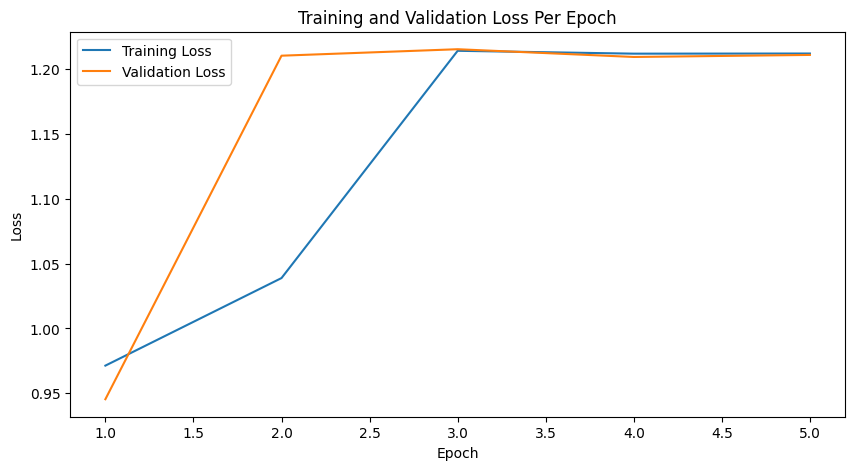

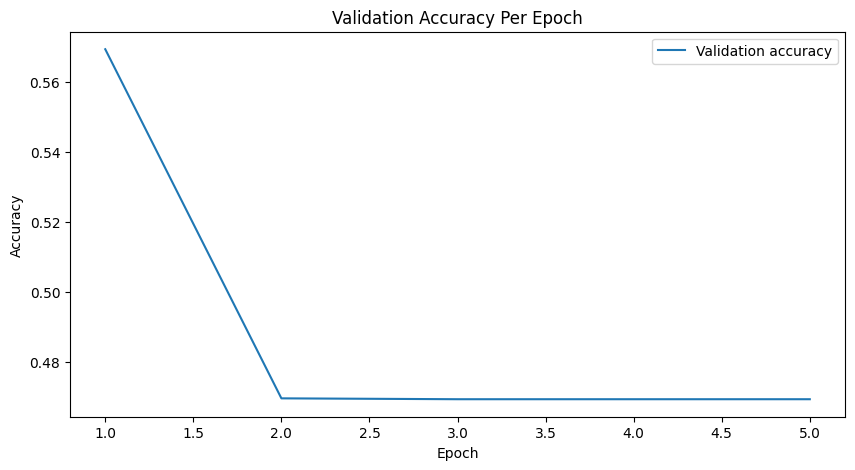

In [ ]:
# Initialize the model
model = BertClassifier(model_name=checkpoint, num_labels=5)
epoch = 1

# Initialize PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=epoch,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,  # Use one GPU if available
)

# Train the model
trainer.fit(model, train_loader, val_loader)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at clicknext/phayathaibert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_f

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
#ดูกราฟ loss
train_loss = []
val_loss = []
val_acc = []
last_train_step = len(model.train_losses) // model.trainer.max_epochs
last_val_step = len(model.val_losses) // model.trainer.max_epochs

for epoch in range(model.trainer.max_epochs):
    start_train_idx = epoch * last_train_step
    end_train_idx = start_train_idx + last_train_step
    start_val_idx = epoch * last_val_step
    end_val_idx = start_val_idx + last_val_step
    train_loss_epoch = sum(model.train_losses[start_train_idx:end_train_idx]) / last_train_step
    val_loss_epoch = sum(model.val_losses[start_val_idx:end_val_idx]) / last_val_step
    val_acc_epoch = sum(model.val_accuaracy[start_val_idx:end_val_idx]) / last_val_step
    train_loss.append(train_loss_epoch)
    val_loss.append(val_loss_epoch)
    val_acc.append(val_acc_epoch)

plt.figure(figsize=(10, 5))
plt.plot(range(1, model.trainer.max_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, model.trainer.max_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Per Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, model.trainer.max_epochs + 1), val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Per Epoch')
plt.legend()
plt.show()

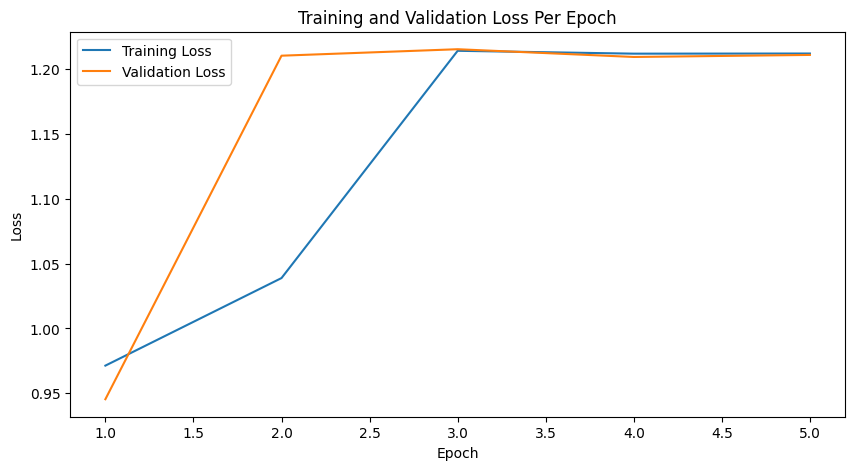

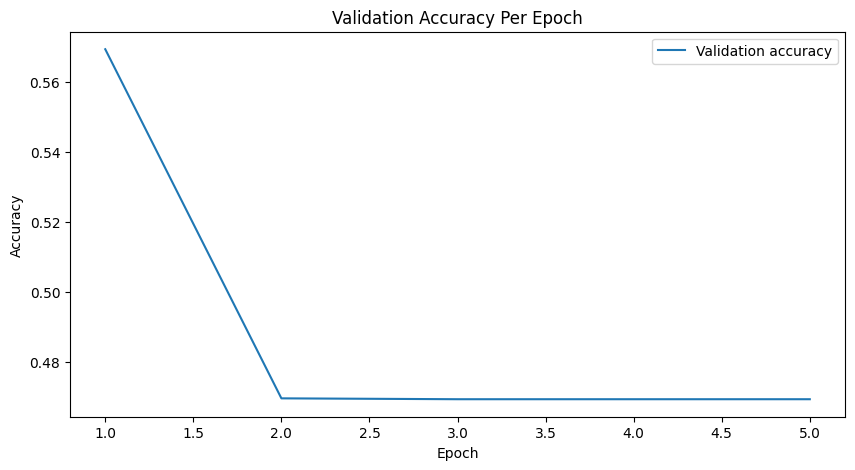

#### Inference finetuned model and evaluate

In [ ]:
#inference model
test_data = raw_datasets["test"]["review_body"][0:500]

# Tokenize and encode texts
encoding = tokenizer(
    test_data,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

# Move data to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
encoding = {key: val.to(device) for key, val in encoding.items()}

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(
        input_ids=encoding['input_ids'],
        attention_mask=encoding['attention_mask']
    )
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    predicted_labels = predictions.cpu().numpy()  # Adjust if necessary

# Display results
for text, label in zip(test_data, predicted_labels):
    print(f"Text: {text}")
    print(f"Predicted Rating: {label}")
    print("-" * 50)
    print("")

Text:      ร้านนี้จะอยู่เส้นสันกำแพง-แม่ออน เลยแยกบ่อสร้างร้านจะอยู่ด้านซ้ายติดริมถนน มีป้ายติดไว้เห็นชัดเจน.."ปูทอง ข้าวแกงรสเด็ด"
     ตามหาข้าวแกงรสชาตินี้มาตลอดในที่สุดก็ได้เจอ เพราะส่วนใหญ่จะเจอรสชาติกลางๆ ถ้าคนชอบรสจัดจ้านแต่ไม่ถึงกับเผ็ดเว่อร์แนะนำร้านนี้เลยค่ะ ที่นั่งก็สะอาดสะอ้าน มีทั้งน้ำซุปและน้ำพริกกะปิฟรี และน้ำดื่มฟรีบริการตัวเอง 
คหสต. ชอบแบบนี้ที่ไม่บังคับให้ลูกค้าต้องซื้อน้ำกินเพราะทานคนเดียวแค่ 1/3 ขวดเหลือทิ้งตลอดเสียดายเงิน
     สั่งกับข้าวราดมา 2 อย่างอร่อยทั้งสองอย่าง เสียดายไข่ดาวหมดซะก่อน แต่แค่ 2 อย่างกับข้าวสวยที่ให้มาในปริมาณที่อิ่มพอดีก็เต็มที่แล้ว แม่ค้าก็อัธยาศัยดีรับรองว่ามีกลับมากิน
อีกบ่อยๆแน่นอน...
     ใครผ่านมาแถวนี้ลองแวะชิมนะคะ สำหรับคนที่ชอบรสกลมกล่อมไม่จืดชืด ????????????
Predicted Rating: 2
--------------------------------------------------

Text: สั่งไป2 เมนู คือมัชฉะลาเต้ร้อน กับ ไอศครีมชาเขียว มัชฉะลาเต้ร้อน รสชาเขียวเข้มข้น หอม มัน แต่ไม่กลมกล่อม มันจืดแบบจืดสนิท ส่วนไอศครีมชาเขียว ทานแล้วรสมันออกใบไม้ๆมากกว่าชาเขียว แล้วก็หวานไป โดยรวมแล้วเ

In [ ]:
#Evaluate finetuned model
rating =[e+1 for e in raw_datasets["test"]["star_rating"][0:500]]
predicted =[e+1 for e in predicted_labels.tolist()]

#Calculate F1-score
f1 = f1_score(rating, predicted,average = "weighted")
print("\nF1-score:", f1)

#Calculate Accuracy
acc = accuracy_score(rating, predicted)
print("\nAccuracy:", acc)

#Classification report
print("\nClassification Report:")
print(classification_report(rating, predicted))


F1-score: 0.5070952837216167

Accuracy: 0.564

Classification Report:
              precision    recall  f1-score   support

           1       0.33      0.20      0.25         5
           2       0.43      0.16      0.23        19
           3       0.53      0.73      0.62       141
           4       0.59      0.71      0.65       243
           5       0.40      0.02      0.04        92

    accuracy                           0.56       500
   macro avg       0.46      0.36      0.36       500
weighted avg       0.53      0.56      0.51       500



####Save and load finetuned model

In [ ]:
#Save model
model.model.save_pretrained('/content/finetuned_phayathaibert/')
tokenizer.save_pretrained('/content/finetuned_phayathaibert/')

#load_model
loaded_tokenizer = AutoTokenizer.from_pretrained("/content/finetuned_phayathaibert/")
loaded_model = AutoModelForSequenceClassification.from_pretrained("/content/finetuned_phayathaibert/")